# Regression on California Housing Dataset with `pytorch`

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from helper_functions import train_regression
from matplotlib.axes import Axes
from matplotlib.ticker import LogFormatter, LogLocator
from sklearn.datasets import fetch_california_housing
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split


In [2]:
plt.style.use(
    [
        f"../mplstyles/{style}.mplstyle"
        for style in ["grid", "science", "notebook", "mylegend"]
    ],
)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device} device")

Using cpu device


## Loading Data

In [4]:
housing = fetch_california_housing()

housing.target = housing.target.reshape(-1, 1)  # pyright: ignore[reportAttributeAccessIssue]

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data: np.ndarray, target: np.ndarray) -> None:
        self.data = torch.tensor(data, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

        self.length = self.data.shape[0]

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int) -> tuple:
        return self.data[idx], self.target[idx]


housing = CustomDataset(housing.data, housing.target)  # pyright: ignore[reportAttributeAccessIssue]

In [6]:
TEST_SET_FRACTION = 0.2

train_set, test_set = random_split(
    housing,
    [1 - TEST_SET_FRACTION, TEST_SET_FRACTION],
    # generator=torch.Generator().manual_seed(31415),
)

This will be important when doing feature normalisation: `train_set` and `test_set` are `Subset` objects. This means that they contain the indices of the traning and test data points respectively, but they don't contain the data itself. Because of this they both point to the complete original dataset through their `dataset` attribute. Therefore, `train_data.dataset` and `test_data.dataset` are the same object.

In [7]:
print(f"{type(train_set) = }")
print(
    "Are train_set.dataset and test_set.dataset the same object?",
    "Yes" if train_set.dataset is test_set.dataset else "No",
)

type(train_set) = <class 'torch.utils.data.dataset.Subset'>
Are train_set.dataset and test_set.dataset the same object? Yes


### Feature normalisation

In [8]:
# Get indices of the training set
train_indices = (
    train_set.indices if hasattr(train_set, "indices") else list(range(len(train_set)))
)
test_indices = (
    test_set.indices if hasattr(test_set, "indices") else list(range(len(test_set)))
)

# Compute mean and std only on training data
data_means = torch.mean(train_set.dataset.data[train_indices], dim=0)  # pyright: ignore[reportAttributeAccessIssue]
data_stds = torch.std(train_set.dataset.data[train_indices], dim=0)  # pyright: ignore[reportAttributeAccessIssue]

# Normalise all data using training statistics
# Note that doing the same operation on test_set.dataset.data would be incorrect
# as train_set.dataset and test_set.dataset are the same object
train_set.dataset.data = (train_set.dataset.data - data_means) / data_stds  # pyright: ignore[reportAttributeAccessIssue]

target_mean = torch.mean(train_set.dataset.target[train_indices], dim=0)  # pyright: ignore[reportAttributeAccessIssue]
target_std = torch.std(train_set.dataset.target[train_indices], dim=0)  # pyright: ignore[reportAttributeAccessIssue]
train_set.dataset.target = (train_set.dataset.target - target_mean) / target_std  # pyright: ignore[reportAttributeAccessIssue]

Check that normalisation happened correctly: if train means are close to 0 and train stds are close to 1, but the same is not true for test means and stds then normalisation was applied correctly

In [9]:
def check_close_to(a: torch.Tensor, b: float, *, expected: bool) -> None:
    """Check that the values in a tensor are close to a given value."""
    close_tensor = b * torch.ones_like(a)
    if torch.allclose(a, close_tensor, atol=1e-5):
        if expected:
            print(f"Values are close to {b}.")
        else:
            raise ValueError(f"Values are unexpectedly close to {b}.")
    else:  # noqa: PLR5501
        if not expected:
            print(f"Values are NOT close to {b}.")
        else:
            raise ValueError(f"Values are unexpectedly NOT close to {b}.")


print("Checking that the mean and std of the training set are close to 0 and 1")
check_close_to(
    torch.mean(train_set.dataset.data[train_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    0,
    expected=True,
)
check_close_to(
    torch.std(train_set.dataset.data[train_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    1,
    expected=True,
)

print("\nChecking that the mean and std of the test set aren't close to 0 and 1")
check_close_to(
    torch.mean(test_set.dataset.data[test_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    0,
    expected=False,
)
check_close_to(
    torch.std(test_set.dataset.data[test_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    1,
    expected=False,
)

print("\nChecking that the mean and std of the training target are close to 0 and 1")
check_close_to(
    torch.mean(train_set.dataset.target[train_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    0,
    expected=True,
)
check_close_to(
    torch.std(train_set.dataset.target[train_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    1,
    expected=True,
)

print("\nChecking that the mean and std of the test target aren't close to 0 and 1")
check_close_to(
    torch.mean(test_set.dataset.target[test_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    0,
    expected=False,
)
check_close_to(
    torch.std(test_set.dataset.target[test_indices], dim=0),  # pyright: ignore[reportAttributeAccessIssue]
    1,
    expected=False,
)

Checking that the mean and std of the training set are close to 0 and 1
Values are close to 0.
Values are close to 1.

Checking that the mean and std of the test set aren't close to 0 and 1
Values are NOT close to 0.
Values are NOT close to 1.

Checking that the mean and std of the training target are close to 0 and 1
Values are close to 0.
Values are close to 1.

Checking that the mean and std of the test target aren't close to 0 and 1
Values are NOT close to 0.
Values are NOT close to 1.


## Training

In [10]:
NUM_EPOCHS = 500
LEARNING_RATE = 1e-3
BATCH_SIZE = 1024
TEST_INTERVAL = 8
SAVEFIG = True

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

train = partial(
    train_regression,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    learning_rate=LEARNING_RATE,
    epochs=NUM_EPOCHS,
    test_interval=TEST_INTERVAL,
)

### Naive benchmark

In [11]:
target_mean = train_set.dataset.target[train_indices].mean()  # pyright: ignore[reportAttributeAccessIssue]
loss_fn = nn.MSELoss()

mean_train_loss = loss_fn(
    target_mean * torch.ones_like(train_set.dataset.target[train_indices]),  # pyright: ignore[reportAttributeAccessIssue]
    train_set.dataset.target[train_indices],  # pyright: ignore[reportAttributeAccessIssue]
)
mean_test_loss = loss_fn(
    target_mean * torch.ones_like(test_set.dataset.target[test_indices]),  # pyright: ignore[reportAttributeAccessIssue]
    test_set.dataset.target[test_indices],  # pyright: ignore[reportAttributeAccessIssue]
)

print(
    f"Train loss: {mean_train_loss.item():.4f}, Test loss: {mean_test_loss.item():.4f}",
)

Train loss: 0.9999, Test loss: 1.0297


### Shallow linear model benchmark

In [12]:
lin_model = nn.Linear(8, 1).to(device)

lin_train_losses, lin_test_losses = train(lin_model)

In [13]:
if lin_test_losses[-1] < mean_test_loss:
    print(
        f"Linear model is better than mean predictor "
        f"({lin_test_losses[-1]:.4f} < {mean_test_loss:.4f})",
    )

Linear model is better than mean predictor (0.3931 < 1.0297)


### Neural Network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_relu_stack(x)

In [15]:
nn_model = NeuralNetwork(8, 1).to(device)
print(nn_model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [16]:
nn_train_losses, nn_test_losses = train(nn_model)

## Plotting

In [17]:
def log_format(ax: Axes) -> None:
    ax.grid(axis="y", which="minor", alpha=0.1)
    ax.set_yscale("log")

    class PlainLogFormatter(LogFormatter):
        def __call__(self, x: float, pos: int | None = None, tol: float = 1e-8) -> str:
            label = super().__call__(x, pos)
            if label == "":
                return ""
            try:
                value = float(x)
                if abs(value - int(value)) < tol:
                    return str(int(value))
                else:  # noqa: RET505
                    return f"{x:.4g}"
            except Exception:  # noqa: BLE001
                return label

    # y-axis ticks
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.yaxis.set_major_formatter(LogFormatter())

    ax.yaxis.set_minor_locator(LogLocator(base=10, subs="auto", numticks=10))
    ax.yaxis.set_minor_formatter(PlainLogFormatter(minor_thresholds=(3, 1)))


### Learning Curves

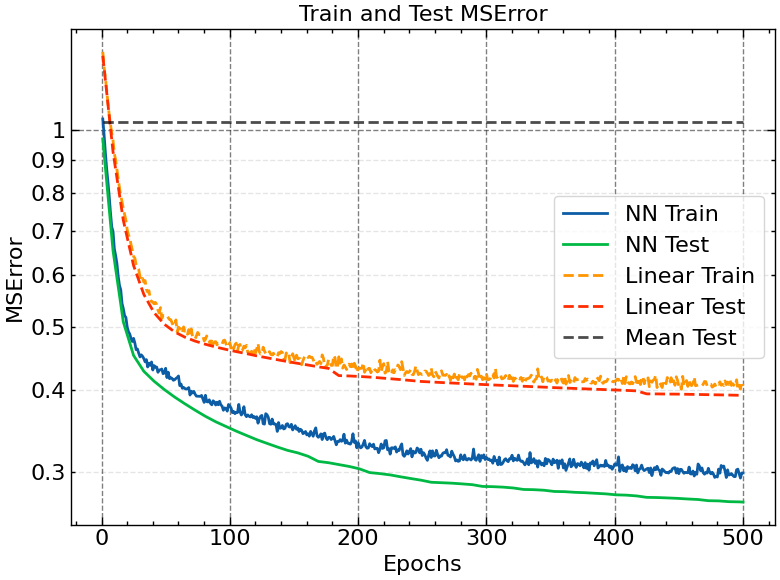

In [18]:
fig, ax = plt.subplots(1, 1)
if TEST_INTERVAL == 1:
    test_epochs = list(range(1, NUM_EPOCHS + 1, TEST_INTERVAL))
else:
    test_epochs = [*list(range(1, NUM_EPOCHS + 1, TEST_INTERVAL)), NUM_EPOCHS]

ax.plot(range(1, NUM_EPOCHS + 1), nn_train_losses, label="NN Train")
ax.plot(test_epochs, nn_test_losses, label="NN Test")
ax.plot(
    range(1, NUM_EPOCHS + 1),
    lin_train_losses,
    label="Linear Train",
    linestyle="--",
)
ax.plot(test_epochs, lin_test_losses, label="Linear Test", linestyle="--")
ax.plot(
    range(1, NUM_EPOCHS + 1),
    mean_test_loss * np.ones_like(nn_train_losses),
    label="Mean Test",
    linestyle="--",
    color="k",
    alpha=0.7,
)

ax.set_title("Train and Test MSError")
ax.set_xlabel("Epochs")
ax.set_ylabel("MSError")

ax.legend()

log_format(ax)

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig(
        f"./images/pytorch_regr_mserror_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png",
        dpi=200,
    )